In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import numpy as np
import seaborn as sns
import os

## Script para procesar los datos  recojidos en el testeo

Nivel Individual:
Precisión: 0.56
Recall: 0.39
F1 Score: 0.46
Exactitud (Accuracy): 0.46
Especificidad: 0.55
Tiempo medio de inferencia: 176.67 ms
Memoria ram media utilizada 65288 bytes


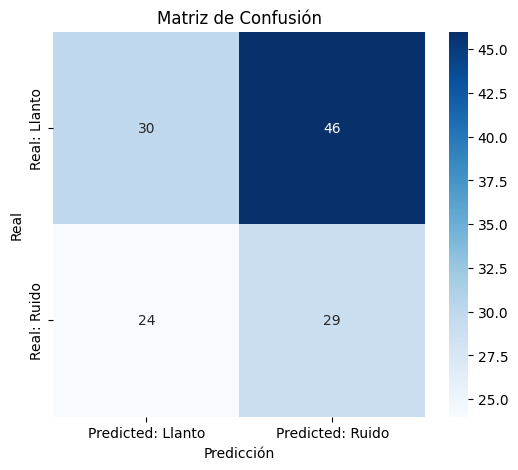

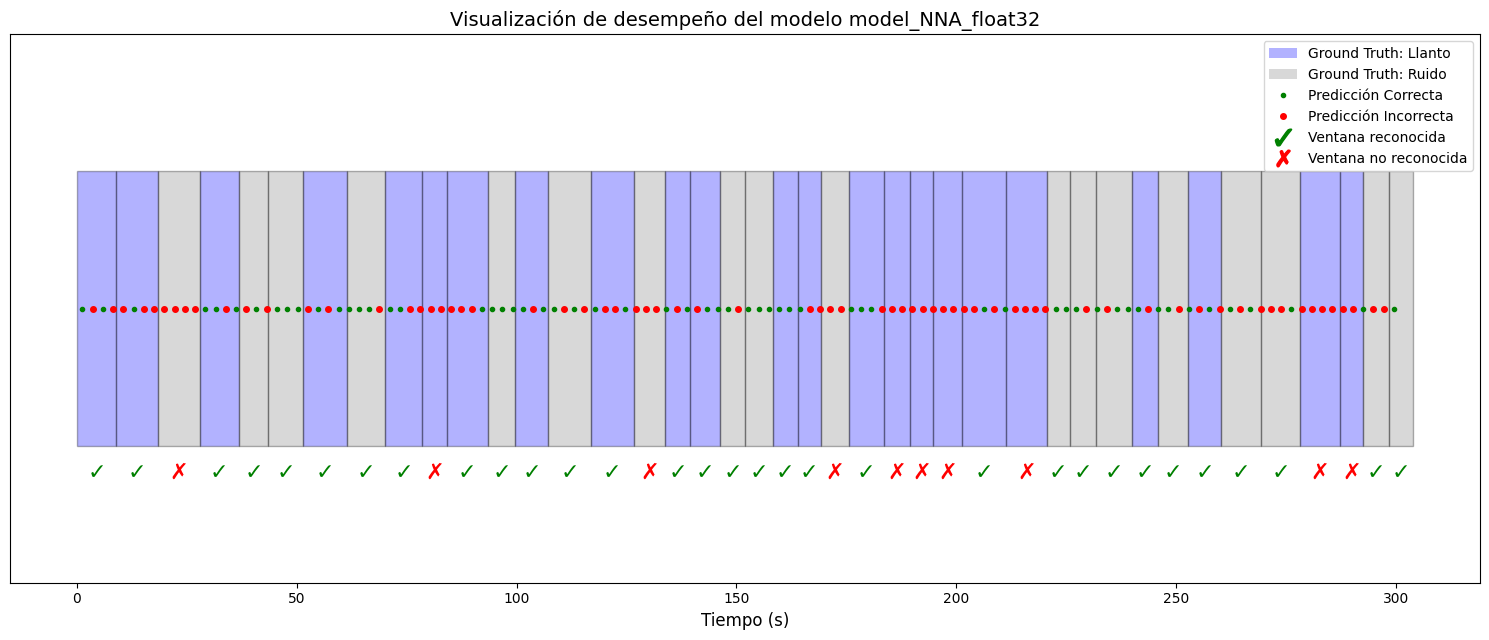

In [ ]:
MODEL_NAME = "model_NNA_float32"

# Cargar el CSV de ground truth
# Se espera que tenga columnas: start_time_ms, end_time_ms, label
annotations = pd.read_csv("audio_for_test/audio_test_10min.csv")

# Convertir tiempos de milisegundos a segundos
annotations['start_sec'] = annotations['start_time_ms'] / 1000.0
annotations['end_sec'] = annotations['end_time_ms'] / 1000.0

# Cargar el csv de resultados experimentales
results = pd.read_csv(f"../Results/model_results/{MODEL_NAME}_results.csv")

# Convertir tiempo a milisegundos
results['time_sec'] = results['timestamp'] / 1000.0

#Función para normalizar las etiquetas a minúsculas.
def normalize(state):
    return state.strip().lower()

# Normalizar las etiquetas (se espera que en ambos CSV se use "Llanto" o "Ruido")
results['norm_detected'] = results['detected_state'].apply(normalize)
annotations['norm_label'] = annotations['label'].apply(normalize)

def get_ground_truth_at_time(t, results_df):
    row = results_df[(results_df['start_sec'] <= t) & (results_df['end_sec'] >= t)]
    if not row.empty:
        return row.iloc[0]['norm_label']
    else:
        return "none"

results['ground_truth'] = results['time_sec'].apply(lambda t: get_ground_truth_at_time(t, annotations))

# Determinar si la predicción es correcta
results['correct'] = results.apply(lambda row: row['norm_detected'] == row['ground_truth'], axis=1)

# Función para determinar si una ventana está reconocida
def window_recognized(start, end, gt_label, results_df):
    # Filtrar las predicciones cuyo tiempo (time_sec) esté en el intervalo [start, end]
    window_results = results_df[(results_df['time_sec'] >= start) & (results_df['time_sec'] <= end)]
    # La ventana se considera reconocida si al menos una predicción coincide con la etiqueta de ground truth
    return any(window_results['norm_detected'] == gt_label)

# Calcular la columna 'recognized' en annotations
annotations['recognized'] = annotations.apply(
    lambda row: window_recognized(row['start_sec'], row['end_sec'], row['norm_label'], results), axis=1
)

# Cálculo de Métricas y Matriz de Confusión
results['TP'] = ((results['norm_detected'] == "llanto") & (results['ground_truth'] == "llanto")).astype(int)
results['FN'] = ((results['norm_detected'] == "ruido") & (results['ground_truth'] == "llanto")).astype(int)
results['FP'] = ((results['norm_detected'] == "llanto") & (results['ground_truth'] == "ruido")).astype(int)
results['TN'] = ((results['norm_detected'] == "ruido") & (results['ground_truth'] == "ruido")).astype(int)

TP = results['TP'].sum() #True Positives (Llanto detectado)
FN = results['FN'].sum() #False Negatives (Llanto no detectado)
FP = results['FP'].sum() #False Positives (Ruido no detectado)
TN = results['TN'].sum() #True Negative (Ruido detectado)

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
avg_inference_time = np.mean(results['inference_time_ms'])
avg_ram_used = np.mean(results['used_ram']).astype(int)

print(f"Nivel Individual:")
print(f"Precisión: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Especificidad: {specificity:.2f}")
print(f"Tiempo medio de inferencia: {avg_inference_time:.2f} ms")
print(f"Memoria ram media utilizada {avg_ram_used} bytes")

conf_matrix = np.array([[TP, FN],
                        [FP, TN]])

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted: Llanto", "Predicted: Ruido"],
            yticklabels=["Real: Llanto", "Real: Ruido"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.savefig(f"../Results/model_graphs/{MODEL_NAME}_confusion_matrix.png")
plt.show()




# Configurar la figura
fig, ax = plt.subplots(figsize=(15, 6.5))

# Dibujar cada intervalo con un rectángulo y un símbolo encima
for idx, row in annotations.iterrows():
    start, end = row['start_sec'], row['end_sec']
    gt_label = row['norm_label']
    recognized = row['recognized']

    # Asignar color de fondo según la etiqueta real
    if gt_label == "llanto":
        face_color = 'blue'
    elif gt_label == "ruido":
        face_color = 'gray'
    else:
        face_color = 'orange'

    # Borde verde si se reconoció, rojo si no
    symbol_color = 'green' if recognized else 'red'

    # Dibujar el rectángulo
    rect = patches.Rectangle((start, 0), end - start, 1, facecolor=face_color,
                             alpha=0.3, edgecolor="black", linewidth=1)
    ax.add_patch(rect)
    symbol = "✓" if recognized else "✗"
    ax.text((start + end) / 2, -0.1, symbol, ha='center', va='center',
            fontsize=16, color=symbol_color)

for _, row in results.iterrows():
    t = row['time_sec']
    if row['correct']:
        ax.plot(t, 0.5, '.', color='green', markersize=6)
    else:
        ax.plot(t, 0.5, '.', color='red', markersize=8)

# Configuración de ejes y título
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel("Tiempo (s)", fontsize=12)
ax.set_yticks([])
ax.set_title(f"Visualización de desempeño del modelo {MODEL_NAME}", fontsize=14)

legend_elements = [
    patches.Patch(facecolor="blue", alpha=0.3, label="Ground Truth: Llanto"),
    patches.Patch(facecolor="grey", alpha=0.3, label="Ground Truth: Ruido"),
    mlines.Line2D([], [], color="green", marker=".", linestyle="None", markersize=6, label="Predicción Correcta"),
    mlines.Line2D([], [], color="red", marker=".", linestyle="None", markersize=8, label="Predicción Incorrecta"),
    mlines.Line2D([], [], color='green', marker='$✓$', linestyle='None',
                  markersize=12, label='Ventana reconocida'),
    mlines.Line2D([], [], color='red', marker='$✗$', linestyle='None',
                  markersize=12, label='Ventana no reconocida')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


##  Script para guardar los  datos  recojidos en cada testeo en el csv

In [ ]:
results_file = f"data/model_results/{MODEL_NAME}_results.csv"
df_res = pd.read_csv(results_file)


metrics_row = {
    "model_name":            MODEL_NAME,
    "precision":             precision,
    "sensibilidad":         recall,
    "f1":                    f1,
    "exactitud":             accuracy,
    "especificidad":         specificity,
    "avg_inference_time_ms": avg_inference_time,
    "avg_used_ram":          avg_ram_used,
}

metrics_file = "data/general_metrics.csv"
fieldnames = [
    "model_name",
    "precision",
    "sensibilidad",
    "f1",
    "exactitud",
    "especificidad",
    "avg_inference_time_ms",
    "avg_used_ram",
]

if os.path.exists(metrics_file):
    df = pd.read_csv(metrics_file)
else:
    df = pd.DataFrame(columns=fieldnames)

if MODEL_NAME in df["model_name"].values:
    df.loc[df["model_name"] == MODEL_NAME, fieldnames] = pd.DataFrame([metrics_row])
else:
    df = pd.concat([df, pd.DataFrame([metrics_row])], ignore_index=True)

df.to_csv(metrics_file, index=False)
print(f"Métricas guardadas en {metrics_file}")


Métricas guardadas en data/general_metrics_new.csv
